In [1]:
# 04_generalization_testing.ipynb
# Predicting cardiovascular disease models on the secondary diabetes dataset

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# setup (libraries, sklearn)
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.impute import SimpleImputer

In [3]:
# paths
project_path = "/content/drive/MyDrive/cardio-ml-project"
data_path = f"{project_path}/data"
models_path = f"{project_path}/models"
results_path = f"{project_path}/results"

# create results folder if not exists
os.makedirs(results_path, exist_ok=True)

In [4]:
# load second dataset (diabetes)

# copy csv from drive into colab temp storage
!cp "/content/drive/MyDrive/cardio-ml-project/diabetes_prediction_dataset.csv" "/content/diabetes.csv"

diabetes = pd.read_csv("/content/diabetes.csv")
diabetes.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
# Feature mapping and feature engineering

# rename relevant columns
diabetes.rename(columns={
    "age": "age_years",
    "blood_glucose_level": "gluc",
    "smoking_history": "smoke"
}, inplace=True)

# fill missing cardio features with 0 (they were not in diabetes dataset)
required_cols = ['age_years','gender','height','weight','bmi','ap_hi','ap_lo','bp_diff',
                 'cholesterol','gluc','smoke','alco','active']
for col in required_cols:
    if col not in diabetes.columns:
        diabetes[col] = 0

# encode smoking
smoke_mapping = {
    "never": 0,
    "No Info": 0,
    "former": 1,
    "current": 1,
    "ever": 1
}
diabetes['smoke'] = diabetes['smoke'].map(smoke_mapping).fillna(0).astype(int)

# encode gender to match cardio dataset (1=female, 2=male)
gender_map = {"Female": 1, "Male": 2}
diabetes['gender'] = diabetes['gender'].map(gender_map).fillna(1).astype(int)

# use only numeric columns that exist
numeric_cols = ['age_years','gender','height','weight','bmi','ap_hi','ap_lo','bp_diff',
                'cholesterol','gluc','smoke','alco','active']
for col in numeric_cols:
    diabetes[col] = pd.to_numeric(diabetes[col], errors='coerce').fillna(0)

In [6]:
# use 'diabetes' column as target
X_diabetes = diabetes[required_cols]
y_diabetes = diabetes['diabetes']

In [7]:
# standardize features
scaler = StandardScaler()
X_diabetes_scaled = X_diabetes.copy()
X_diabetes_scaled[required_cols] = scaler.fit_transform(X_diabetes[required_cols])

In [8]:
# load models
import os
tuned_model_files = [f for f in os.listdir(models_path) if f.endswith("_tuned.pkl")]

In [9]:
# Evaluate models on diabetes dataset

generalization_results = []

for model_file in tuned_model_files:
    model_name = model_file.replace("_tuned.pkl", "").replace("_", " ")

    # load model
    model = joblib.load(f"{models_path}/{model_file}")

    # predict (convert DataFrame -> numpy to avoid feature name warning)
    y_pred = model.predict(X_diabetes.values)
    y_proba = model.predict_proba(X_diabetes.values)[:, 1] if hasattr(model, "predict_proba") else None

    # metrics
    row = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_diabetes, y_pred),
        "Precision": precision_score(y_diabetes, y_pred),
        "Recall": recall_score(y_diabetes, y_pred),
        "F1": f1_score(y_diabetes, y_pred),
        "ROC-AUC": roc_auc_score(y_diabetes, y_proba) if y_proba is not None else None
    }
    generalization_results.append(row)

# save and display
generalization_df = pd.DataFrame(generalization_results)
generalization_df.to_csv(f"{results_path}/generalization_results.csv", index=False)
print("Generalization testing completed.")
display(generalization_df)

Generalization testing completed.


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Random Forest,0.08500,0.085000,1.000000,0.156682,0.503902
1,KNN,0.08500,0.085000,1.000000,0.156682,0.599774
2,Logistic Regression,0.34227,0.107197,0.919412,0.192008,0.640827
3,Decision Tree,0.91318,0.000000,0.000000,0.000000,0.503962
4,SVM,0.08500,0.085000,1.000000,0.156682,0.500000
5,XGBoost,0.08771,0.085231,1.000000,0.157074,0.468245
6,Extra Trees,0.08621,0.085103,1.000000,0.156857,0.489966
7,Neural Net (MLP),0.10446,0.086678,0.999882,0.159528,0.726086


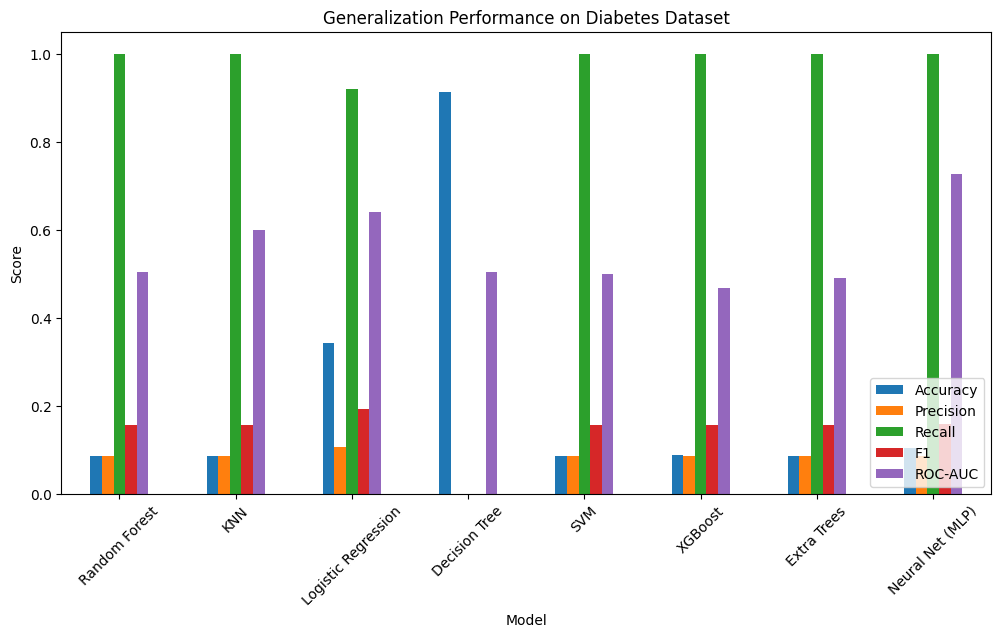

In [11]:
# plot metrics

metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
generalization_df.plot(x="Model", y=metrics, kind="bar", figsize=(12,6))
plt.title("Generalization Performance on Diabetes Dataset")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

In [10]:
# Threshold tuning

# load tuned models into a dict
models = {}
for file in tuned_model_files:
    model_name = file.replace("_tuned.pkl", "")
    models[model_name] = joblib.load(os.path.join(models_path, file))

# threshold tuning

results = []

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_diabetes.values)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_diabetes.values)
    else:
        print(f"Skipping {name}: no probability or decision function")
        continue

    best_f1, best_thresh = 0, 0.5
    for thresh in np.linspace(0.1, 0.9, 17):  # thresholds 0.1 → 0.9
        y_pred_thresh = (y_scores >= thresh).astype(int)
        f1 = f1_score(y_diabetes, y_pred_thresh, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thresh = f1, thresh

    # final predictions with best threshold
    y_pred_final = (y_scores >= best_thresh).astype(int)

    results.append({
        "Model": name,
        "Best Threshold": best_thresh,
        "Accuracy": (y_diabetes == y_pred_final).mean(),
        "Precision": precision_score(y_diabetes, y_pred_final, zero_division=0),
        "Recall": recall_score(y_diabetes, y_pred_final, zero_division=0),
        "F1": f1_score(y_diabetes, y_pred_final, zero_division=0),
        "ROC-AUC": roc_auc_score(y_diabetes, y_scores)
    })

# show results table
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Best Threshold  Accuracy  Precision    Recall  \
0        Random_Forest            0.10   0.08500   0.085000  1.000000   
1                  KNN            0.75   0.35522   0.107216  0.898824   
2  Logistic_Regression            0.90   0.41254   0.113469  0.867647   
3        Decision_Tree            0.10   0.09407   0.085778  1.000000   
4                  SVM            0.10   0.08500   0.085000  1.000000   
5              XGBoost            0.55   0.09016   0.085441  1.000000   
6          Extra_Trees            0.55   0.09588   0.085935  1.000000   
7     Neural_Net_(MLP)            0.90   0.18420   0.094243  0.998471   

         F1   ROC-AUC  
0  0.156682  0.503902  
1  0.191580  0.599774  
2  0.200691  0.640827  
3  0.158003  0.503962  
4  0.156682  0.500000  
5  0.157431  0.468245  
6  0.158269  0.489966  
7  0.172230  0.726086  


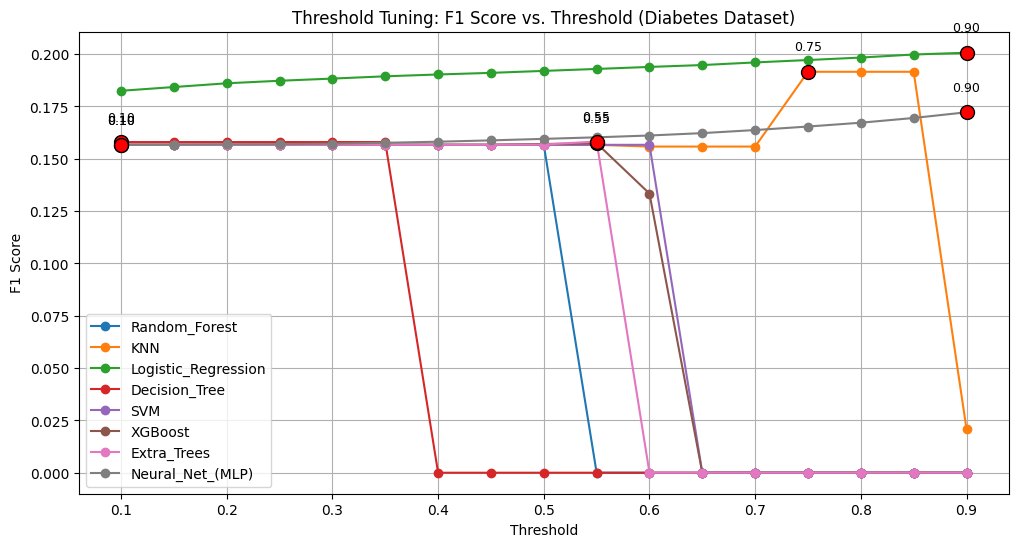

In [13]:
# visualize threshold tuning

plt.figure(figsize=(12, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_diabetes.values)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_diabetes.values)
    else:
        continue

    thresholds = np.linspace(0.1, 0.9, 17)
    f1_scores = []

    best_f1, best_thresh = 0, 0.5
    for thresh in thresholds:
        y_pred_thresh = (y_scores >= thresh).astype(int)
        f1 = f1_score(y_diabetes, y_pred_thresh, zero_division=0)
        f1_scores.append(f1)
        if f1 > best_f1:
            best_f1, best_thresh = f1, thresh

    plt.plot(thresholds, f1_scores, marker='o', label=name)
    plt.scatter(best_thresh, best_f1, color='red', s=100, edgecolor='k', zorder=5)
    plt.text(best_thresh, best_f1+0.01, f"{best_thresh:.2f}", ha='center', fontsize=9)

plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold Tuning: F1 Score vs. Threshold (Diabetes Dataset)")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Summary table

# convert results into DataFrame
threshold_summary_df = pd.DataFrame(results)

# select relevant columns
threshold_summary_df = threshold_summary_df[["Model", "Best Threshold", "F1"]]

# sort by F1 descending
threshold_summary_df.sort_values(by="F1", ascending=False, inplace=True)

# reset index
threshold_summary_df.reset_index(drop=True, inplace=True)

# display table
print("Threshold Tuning Summary:")
display(threshold_summary_df)

# save to CSV
threshold_summary_df.to_csv(f"{results_path}/threshold_tuning_summary.csv", index=False)

Threshold Tuning Summary:


,Model,Best Threshold,F1
0,Logistic_Regression,0.90,0.200691
1,KNN,0.75,0.191580
2,Neural_Net_(MLP),0.90,0.172230
3,Extra_Trees,0.55,0.158269
4,Decision_Tree,0.10,0.158003
5,XGBoost,0.55,0.157431
6,Random_Forest,0.10,0.156682
7,SVM,0.10,0.156682


In [15]:
# Combined summary table

# load results
baseline_df = pd.read_csv(f"{results_path}/baseline_results.csv")
tuned_df = pd.read_csv(f"{results_path}/tuned_results.csv")
generalization_df = pd.read_csv(f"{results_path}/generalization_results.csv")

# keep relevant metrics
baseline_df = baseline_df[['Model','Accuracy','Precision','Recall','F1','ROC-AUC']].copy()
tuned_df = tuned_df[['Model','Accuracy','Precision','Recall','F1','ROC-AUC']].copy()
generalization_df = generalization_df[['Model','Accuracy','Precision','Recall','F1','ROC-AUC']].copy()

# add column to identify source
baseline_df['Stage'] = 'Baseline'
tuned_df['Stage'] = 'Tuned'
generalization_df['Stage'] = 'Generalization'

# combine
summary_df = pd.concat([baseline_df, tuned_df, generalization_df], ignore_index=True)
summary_df

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,Stage
0,Neural Net (MLP),0.730500,0.740990,0.708262,0.724256,0.730487,Baseline
1,XGBoost,0.730500,0.747125,0.696398,0.720870,0.730481,Baseline
2,SVM,0.724786,0.740254,0.692110,0.715373,0.724767,Baseline
3,Logistic Regression,0.714214,0.731847,0.675672,0.702638,0.714192,Baseline
4,Random Forest,0.709643,0.713350,0.700400,0.706816,0.709638,Baseline
5,KNN,0.645500,0.651603,0.624500,0.637764,0.645488,Baseline
6,Decision Tree,0.637071,0.642464,0.617210,0.629584,0.637060,Baseline
7,KNN,0.656143,0.663863,0.631790,0.647429,0.701553,Tuned
8,Logistic Regression,0.714143,0.731734,0.675672,0.702586,0.778152,Tuned
9,Random Forest,0.730857,0.757006,0.679531,0.716180,0.797870,Tuned


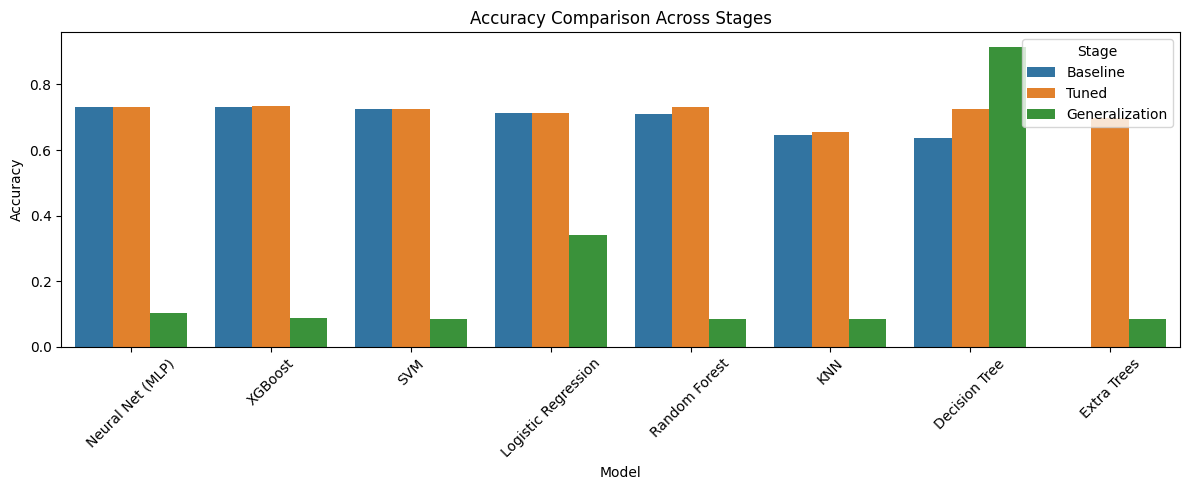

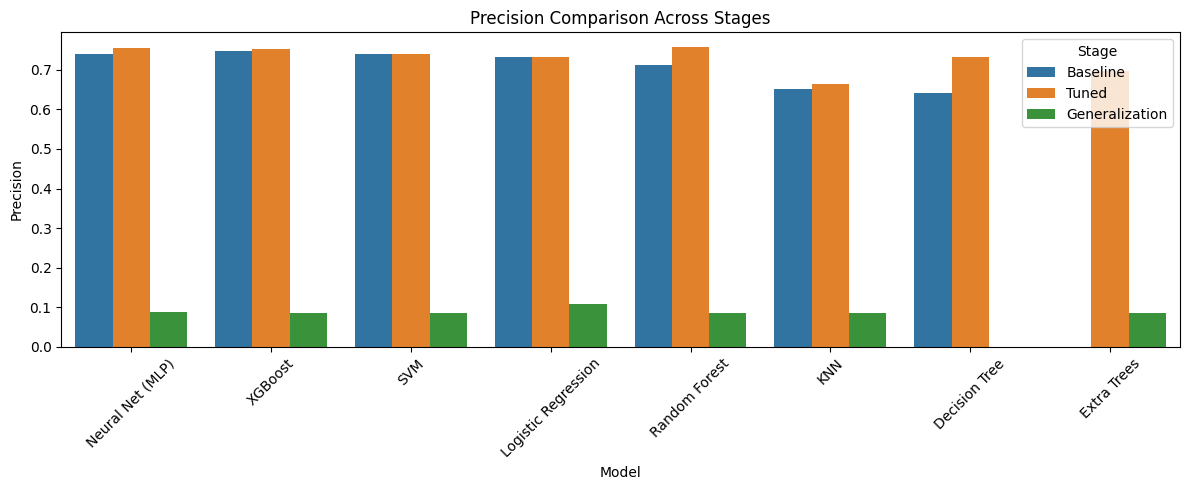

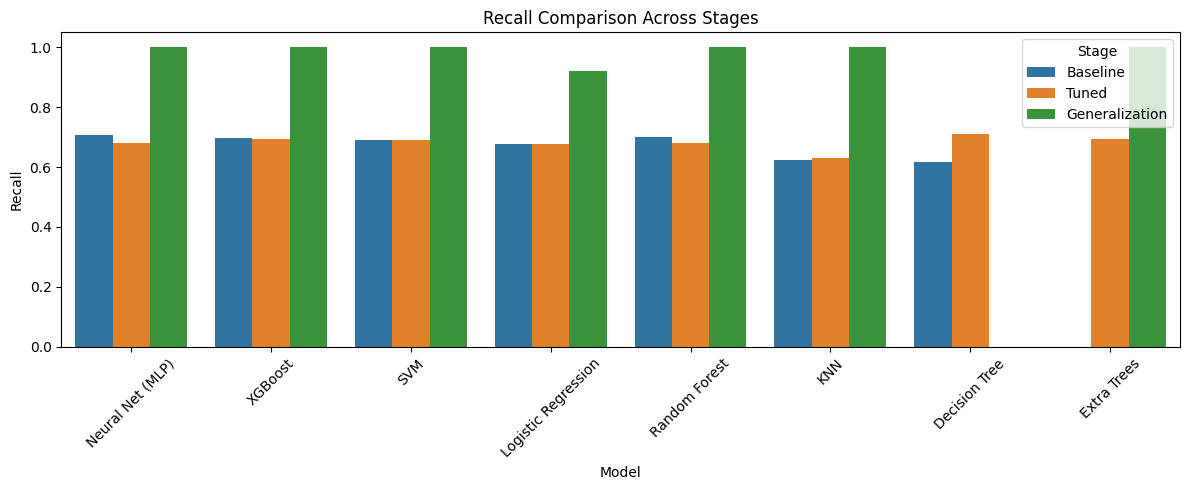

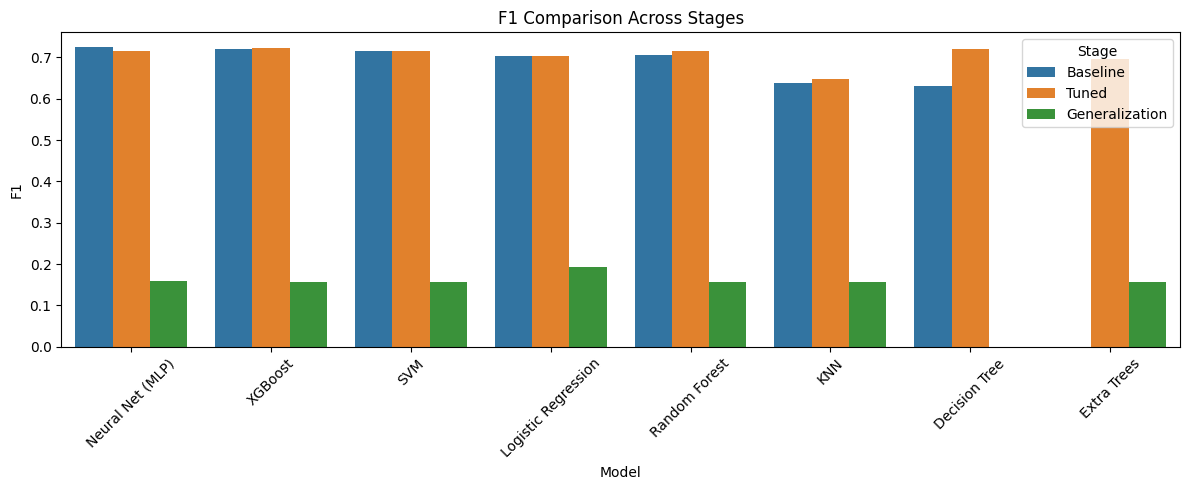

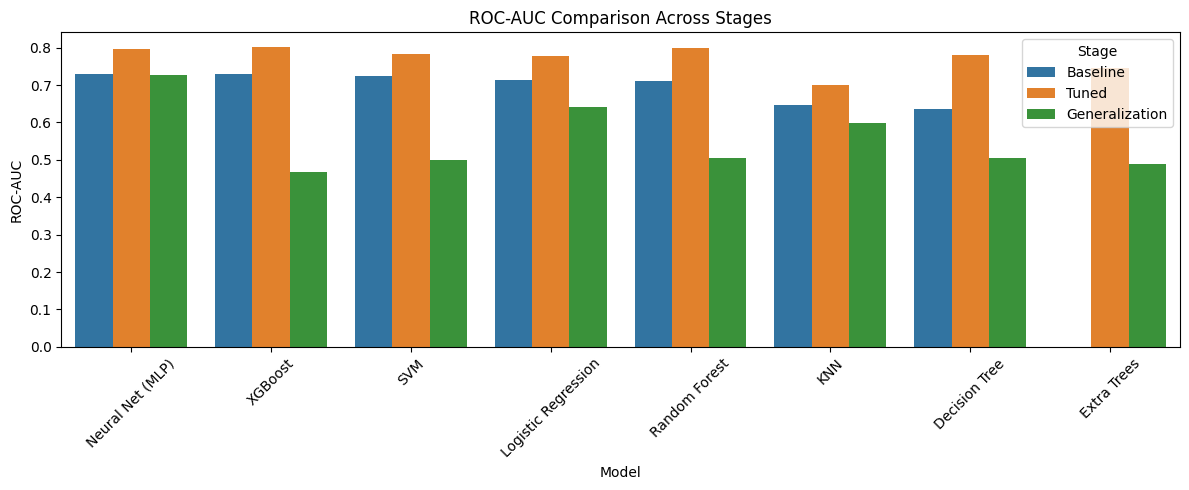

In [16]:
import seaborn as sns

metrics = ['Accuracy','Precision','Recall','F1','ROC-AUC']

for metric in metrics:
    plt.figure(figsize=(12,5))
    sns.barplot(x='Model', y=metric, hue='Stage', data=summary_df)
    plt.title(f"{metric} Comparison Across Stages")
    plt.xticks(rotation=45)
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.legend(title="Stage")
    plt.tight_layout()
    plt.show()